In [131]:
#!/anaconda/bin/python
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 
#%matplotlib
from tqdm import tqdm_notebook
from datetime import datetime
from scipy.special import eval_legendre
from numpy.linalg import inv
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import eval_legendre

In [132]:
R = 1
n_particles = 100
beta = 10**(-7)
b = 1
a = 1

In [161]:
def init_state(n_particles):
    '''
    Place particles randomly on a spherical surface.
    '''
    
    state = np.zeros((n_particles, 3))
    
    for i in range(0, n_particles):
        
        z_rand = R*(2*np.random.random()-1)
        phi_rand = 2*np.pi*np.random.random()
        x_rand = np.sqrt(R**2 - z_rand**2)*np.cos(phi_rand)
        y_rand = np.sqrt(R**2 - z_rand**2)*np.sin(phi_rand)
        
        state[i][0], state[i][1], state[i][2] = x_rand, y_rand, z_rand
    
    return state

def get_dists(state):
    '''Returns an array of all distances between all pairs of particles.'''
    
    return np.sqrt(np.sum(((state[:, np.newaxis] - state)**2),axis=2))[np.triu_indices(n_particles,1)]

def get_cosines(state):
    '''Returns an array of all cosines between all pairs of particles.'''
    
    return np.sum((state[:, np.newaxis]*state),axis=2)[np.triu_indices(n_particles,1)]/(R**2)
    
def E(dists):
    '''
    Takes an array of distances between pairs of particles
    and returns the total (potential) energy of the config.
    '''
    
    return np.sum(b*((a/dists)**12 - 2*(a/dists)**6))

def step_fwd(vec, sigma):
    '''Push a single particle around uniformly.'''
    
    dvec = np.array([np.random.normal(0,sigma) for i in range(len(vec))])
    vec  = vec + dvec
    
    vec_normed = R*vec/np.sqrt(vec.dot(vec))
    
    return vec_normed

def metropolis(n_iters, n_bins, state):
    
    print('Running MCMC.')
    print('Beta = ' + str(beta) + '.')
    print('Number of particles = ' + str(n_particles) +'.')
    
    sigma = .01
    bin_edges = np.linspace(-1, 1, n_bins + 1) 
    hist = np.zeros(n_bins)
    
    acceptance_tally = 0
    running_acceptance_tally = 0
    adjust_sigma_steps = 100

    for i in tqdm_notebook(range(n_iters)):
    
        particle_no = np.random.randint(0,n_particles)
        
        candidate_state = np.copy(state)  
        
        candidate_state[particle_no] = step_fwd(candidate_state[particle_no], sigma)

        dists_state =  get_dists(state)
        dists_candidate  =  get_dists(candidate_state)
    
        # if dE < 0, move decreases energy (more likely)
        # if dE > 0, move increases energy (less likely)
        # if dE = 0, move doesn't do anything to energy (equally likely)
        
        dE = E(dists_candidate)-E(dists_state)

        if dE <= 0:
            state = candidate_state
            acceptance_tally += 1
            running_acceptance_tally +=1
            
        else:
            q = np.float64(np.exp(-beta*dE))
            
            # 0 <= q < 1 since dE > 0.
            # generate random number between zero and 1
            p = np.random.random()

            if p < q:
                state = candidate_state
                acceptance_tally += 1
                running_acceptance_tally +=1
        
        cosines = get_cosines(state)
        hist = hist + np.histogram(cosines, bin_edges)[0]
            
        # this decreases sigma if the acceptance rate is too low
        # or increases if it's too high
        if (i % adjust_sigma_steps == 0) and (i != 0):
            mean_acceptance = running_acceptance_tally/adjust_sigma_steps
            if mean_acceptance < .23:
                sigma = sigma * .9
            if mean_acceptance > .23:
                sigma = sigma * 1/.9
            running_acceptance_tally = 0
        
    acceptance_rate = (acceptance_tally/n_iters)*100
            
    print('Completed ', n_iters, ' iterations.')
    print('The acceptance rate for this run was: ', acceptance_rate, ' %.')
    
    normalized_hist = hist*(n_particles-1)/(np.sum(hist)*(bin_edges[1]-bin_edges[0]))
    
    return normalized_hist, bin_edges, acceptance_rate, state

In [106]:
n_particles = 100
state = init_state(n_particles)

In [150]:
n_iters = 2*10**5
n_bins = 1000
hist, bin_edges, acc, state = metropolis(n_iters, n_bins, state)

Running MCMC.
Beta = 1e-07.
Number of particles = 100.

Completed  200000  iterations.
The acceptance rate for this run was:  23.579  %.


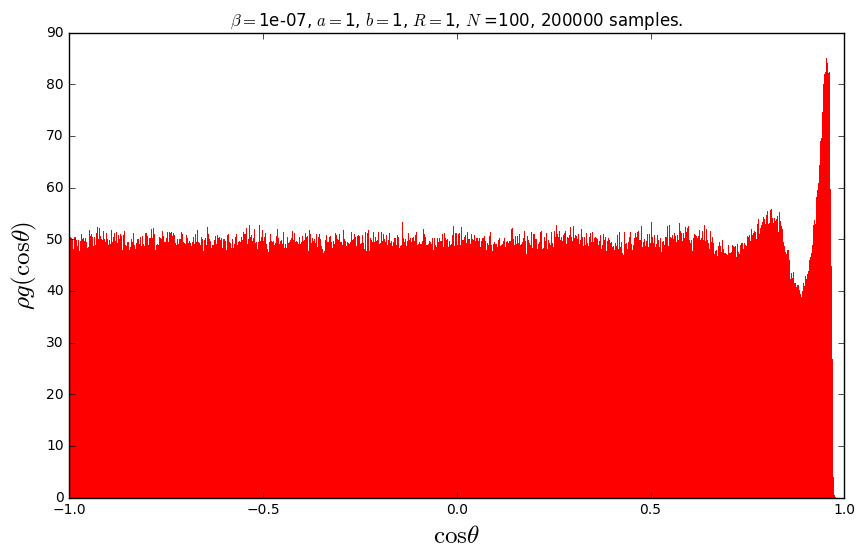

In [177]:
plt.figure(figsize=(10,6), dpi = 80)

plt.bar(bin_edges[:-1], hist, width = np.diff(bin_edges), edgecolor = 'none', color = 'red')

plt.title('$\\beta =${0}'.format(beta)  + ', $a = $' \
          + str(a) + ', $b =$' +str(b) + ', $R=$' \
          + str(R) + ', ' + '$N$ =' + str(n_particles) \
          + ', ' + str(n_iters) + ' samples.')

plt.ylabel('$\\rho g(\cos\\theta)$', fontsize = 18)
plt.xlabel('$\cos\\theta$', fontsize = 18)
plt.savefig('rg_x_mcmc_beta_1e-7.png')

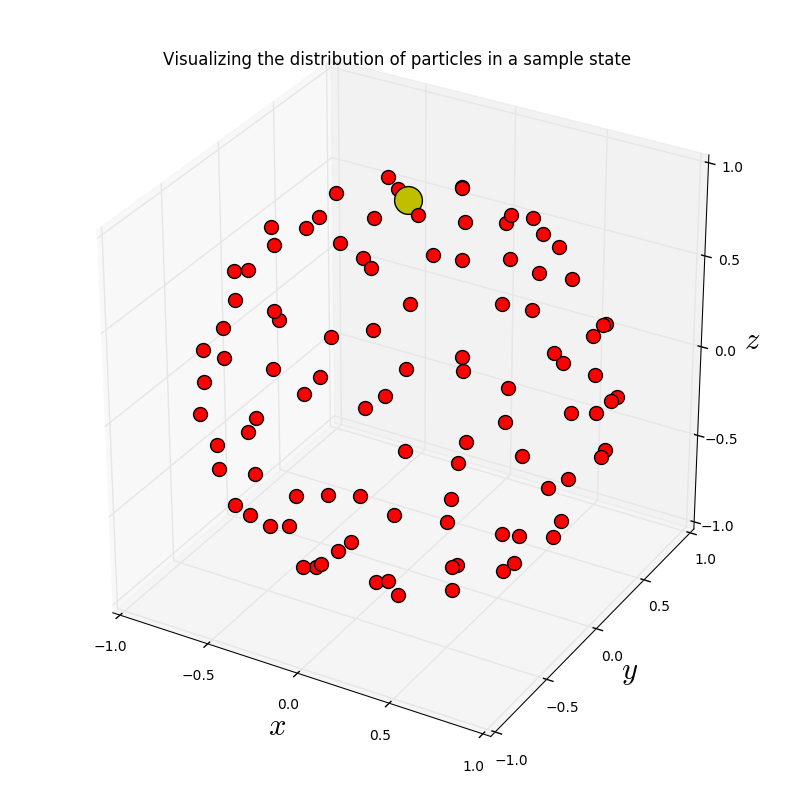

In [166]:
'''
The code below is to help visualize the state.
'''
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')

for v in state:
    ax.scatter(v[0], v[1], v[2], zdir = 'z', c = 'r', s = 100)

ax.scatter(0,0,1, zdir = 'z', c = 'y', s = 400)

plt.title('Visualizing the distribution of particles in a sample state')
ax.set_xlabel('$x$', fontsize=22)
ax.set_ylabel('$y$', fontsize=22)
ax.set_zlabel('$z$', fontsize=22)
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)

plt.show()
plt.savefig('rg_x_mcmc_beta_1e-7_visual.png')

In [167]:
L_max = 50

def get_legendre_cfs(f, L, n_bins):
    
    dx = 2 / n_bins
    xs = np.linspace(-1, 1, n_bins)

    legendre_L = eval_legendre(L, xs)
    
    return ((2*L+1)/2)*dx*np.dot(f, legendre_L)

Ls = [L for L in range(L_max)]

rg_L = [get_legendre_cfs(hist, L, n_bins) for L in range(L_max)]

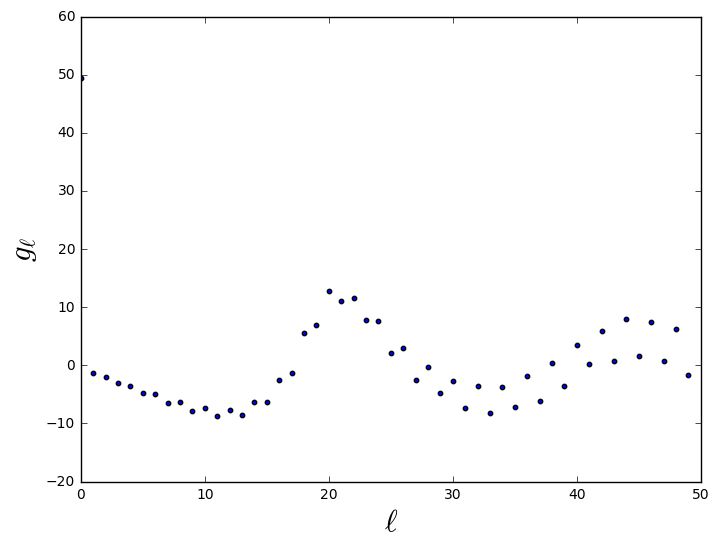

In [168]:
plt.figure(figsize=(8,6), dpi = 80)
plt.scatter(Ls, rg_L, s = 10)
plt.xlim(0,L_max)
plt.ylabel('$g_\ell$', fontsize = 22)
plt.xlabel('$\ell$', fontsize = 22)

In [169]:
def rg_x(x, L_max):
    '''Calculates \rho g(x) as an expansion
    in Legendre polynomials up to L_max'''
    
    legendre_L_x = [eval_legendre(L,x) for L in range(L_max)]
    
    return np.dot(rg_L, legendre_L_x)

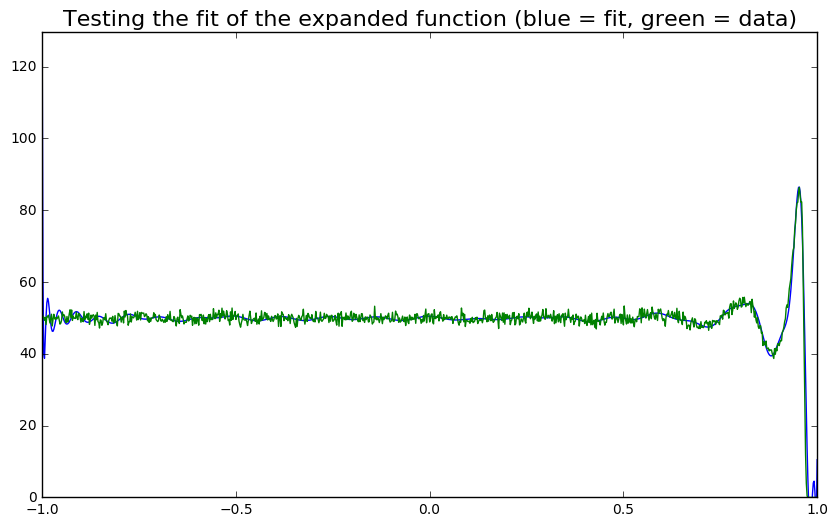

In [174]:
plt.figure(figsize=(10,6), dpi = 80)

plt.ylim(0,np.max(hist)*1.5)

xs = np.linspace(-1,1,n_bins)
plt.plot(xs, rg_x(xs, L_max), linewidth = 1)

plt.plot(bin_edges[:-1], hist)

plt.title('Testing the fit of the expanded function (blue = fit, green = data)', fontsize = 16)

plt.savefig('testing_fit_beta_1e-7')

In [175]:
a_L = [(1/n_particles)*((2*L+1/(4*np.pi)) + rg_L[L])**(-1) for L in range(L_max)]

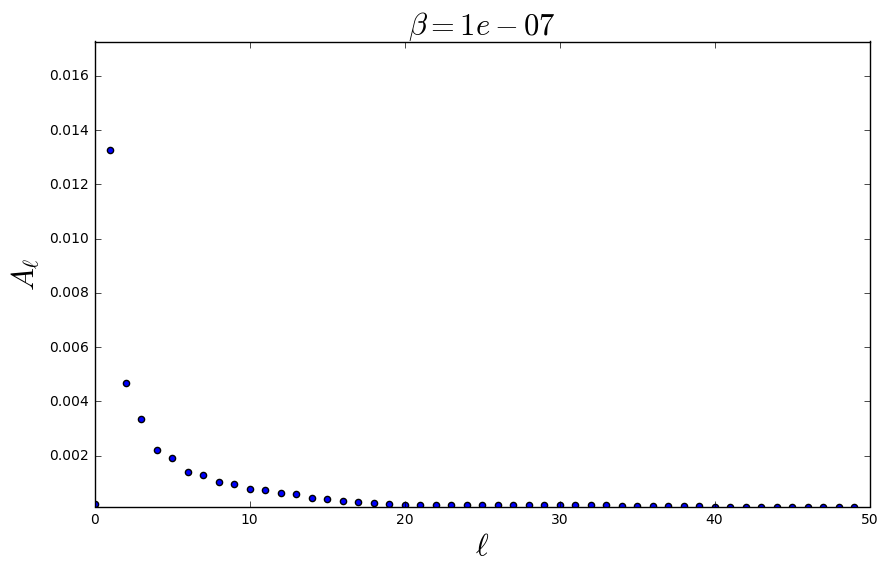

In [176]:
plt.figure(figsize=(10,6), dpi = 80)

plt.scatter(Ls, a_L)
plt.ylim(np.min(a_L)*1.3,np.max(a_L)*1.3)
plt.axhline(0)
plt.title('$\\beta = %s$' % beta, fontsize = 22)
plt.ylabel('$A_\ell$', fontsize = 22)
plt.xlabel('$\ell$', fontsize = 22)
plt.xlim(0,L_max)

plt.savefig('a_L_1e-7')